In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [2]:
import pickle
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

from tqdm.notebook import tqdm
from pathlib import Path

import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (transform['train'] if self.mode == 'train' else transform['val_test'])

        x = self.load_sample(self.files[index])
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Я переименовал названия папок с train/test датасетами.

In [6]:
TRAIN_DIR = Path('data/train')
TEST_DIR = Path('data/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

### Расширим каждый класс до длины >= 100. Не будет явных 'просадок' в распознавании классов с маленьким количеством картинок.
#### Применена техника data augumentation

In [8]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

dct_path_train = create_dct_path_labels(train_files, train_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

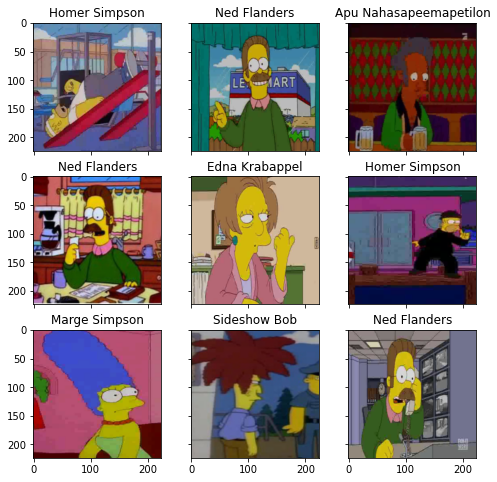

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

#### Efficient net-b7


In [11]:
from efficientnet_pytorch import EfficientNet

model_extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=42)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model_extractor.parameters())

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

model_extractor.to(DEVICE)

Loaded pretrained weights for efficientnet-b7


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    losses = []
  
    for idx, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        if idx % 50 == 0:
            losses.append(loss.item())
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc, losses

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [14]:
def train(model, criterion, opt, scheduler, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    all_losses = []

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc, losses = fit_epoch(model, train_loader, criterion, opt)
            all_losses += losses
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history, all_losses

In [15]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [16]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


Запустим обучение сети.

In [17]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [18]:
history, total_loss = train(model=model_extractor, criterion=criterion, opt=optimizer, scheduler=scheduler, epochs=20 , batch_size=8)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2112 [00:00<?, ?it/s]

loss 1.1055894428304611

Epoch 001 train_loss: 1.1056     val_loss 0.6580 train_acc 0.7145 val_acc 0.8424


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.7371400470948587

Epoch 002 train_loss: 0.7371     val_loss 0.4590 train_acc 0.8097 val_acc 0.8884


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.45785965715146293

Epoch 003 train_loss: 0.4579     val_loss 0.4324 train_acc 0.8788 val_acc 0.8999


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.18898142681176194

Epoch 004 train_loss: 0.1890     val_loss 0.1562 train_acc 0.9497 val_acc 0.9650


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.17120071489727867

Epoch 005 train_loss: 0.1712     val_loss 0.1778 train_acc 0.9544 val_acc 0.9627


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.15130121091967128

Epoch 006 train_loss: 0.1513     val_loss 0.1760 train_acc 0.9587 val_acc 0.9582


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.07143418069764457

Epoch 007 train_loss: 0.0714     val_loss 0.1284 train_acc 0.9814 val_acc 0.9690


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.05492579804212163

Epoch 008 train_loss: 0.0549     val_loss 0.1523 train_acc 0.9847 val_acc 0.9654


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.05532091878343171

Epoch 009 train_loss: 0.0553     val_loss 0.1418 train_acc 0.9859 val_acc 0.9727


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.02538518243233806

Epoch 010 train_loss: 0.0254     val_loss 0.1246 train_acc 0.9927 val_acc 0.9761


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.01929293643168266

Epoch 011 train_loss: 0.0193     val_loss 0.1275 train_acc 0.9950 val_acc 0.9754


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.02113771852319147

Epoch 012 train_loss: 0.0211     val_loss 0.1257 train_acc 0.9940 val_acc 0.9765


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.00804242047801923

Epoch 013 train_loss: 0.0080     val_loss 0.1426 train_acc 0.9976 val_acc 0.9761


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.008721451412195024

Epoch 014 train_loss: 0.0087     val_loss 0.1297 train_acc 0.9977 val_acc 0.9778


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.0073507005353407005

Epoch 015 train_loss: 0.0074     val_loss 0.1357 train_acc 0.9980 val_acc 0.9767


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.004443234111967525

Epoch 016 train_loss: 0.0044     val_loss 0.1288 train_acc 0.9989 val_acc 0.9796


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.0022198267050142135

Epoch 017 train_loss: 0.0022     val_loss 0.1310 train_acc 0.9995 val_acc 0.9797


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.0031281619468540856

Epoch 018 train_loss: 0.0031     val_loss 0.1391 train_acc 0.9990 val_acc 0.9807


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.002028569341222034

Epoch 019 train_loss: 0.0020     val_loss 0.1390 train_acc 0.9995 val_acc 0.9811


  0%|          | 0/2112 [00:00<?, ?it/s]

loss 0.001539850447602475

Epoch 020 train_loss: 0.0015     val_loss 0.1420 train_acc 0.9993 val_acc 0.9815


Построим кривые обучения

In [19]:
loss, acc, val_loss, val_acc = zip(*history)

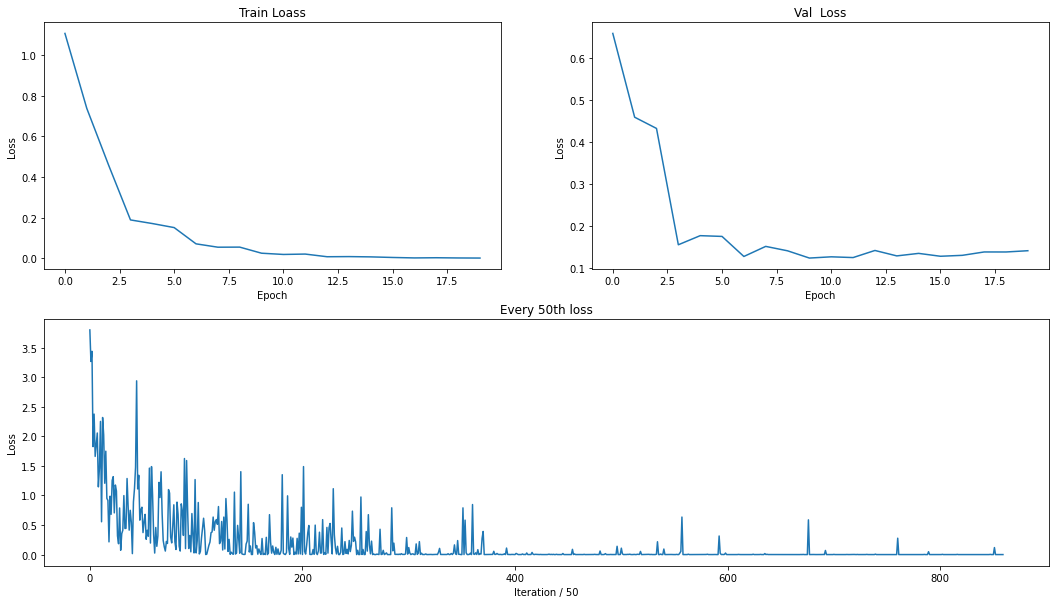

In [50]:
import seaborn as sns

fig = plt.figure(figsize=(18, 10))


gs = fig.add_gridspec(2,2)

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
ax_3 = fig.add_subplot(gs[1, :])

ax_1.set_title('Train Loass')
ax_1.set_xlabel('Epoch')
ax_1.set_ylabel('Loss')

ax_2.set_title('Val  Loss')
ax_2.set_xlabel('Epoch')
ax_2.set_ylabel('Loss')

ax_3.set_title('Every 50th loss')
ax_3.set_xlabel('Iteration / 50')
ax_3.set_ylabel('Loss')

sns.lineplot(ax=ax_1, data=loss);
sns.lineplot(ax=ax_2, data=val_loss);
sns.lineplot(ax=ax_3, data=total_loss);


### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [21]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [22]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [23]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [24]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [25]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

0.95

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

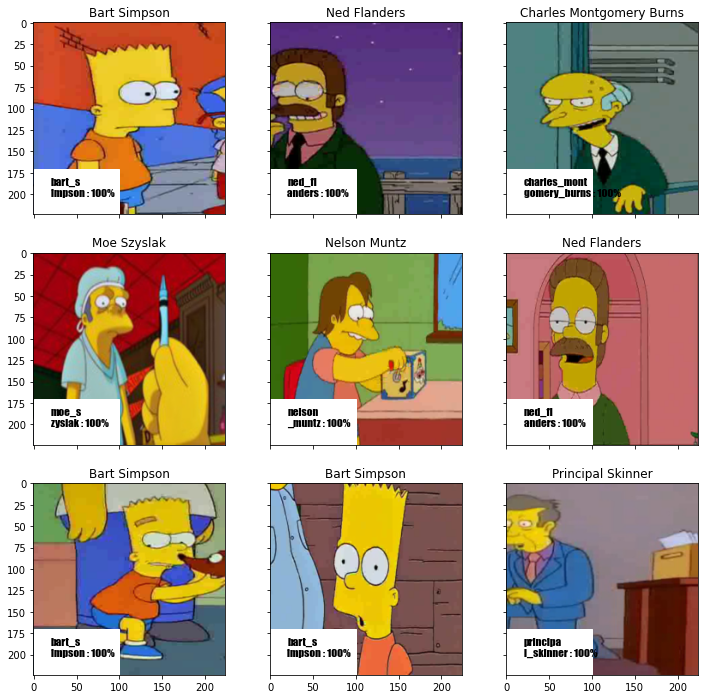

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 170),100,70,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(20, 180, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=11, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

### В данном случае я решил отсортировать все пути (названия файлов) по порядковому номеру.

In [51]:
import re

sort_path_by_count = lambda x : int(re.sub(r"[^0-9]", "", str(x)))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')), key = sort_path_by_count)

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [52]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson


In [53]:
my_submit.to_csv('sample_submission.csv', index=False)

In [ ]:
# torch.save(model_exctractor, 'model')